In [1]:
# Импорт необходимых библиотек
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.feature_extraction.text import TfidfVectorizer


In [2]:
# Загрузка обучающего и тестового наборов данных из CSV файлов
train=pd.read_csv('/content/train.csv')
test=pd.read_csv('/content/test.csv')

In [3]:
# Загрузка обучающего и тестового наборов данных из CSV файлов
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
# Загрузка обучающего и тестового наборов данных из CSV файлов
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
# Загрузка только необходимых столбцов из обучающего и тестового наборов данных для экономии памяти
train=pd.read_csv('/content/train.csv',usecols=[0,3,4])
test=pd.read_csv('/content/test.csv',usecols=[0,3])

In [6]:
# Просмотр первых нескольких строк после загрузки только необходимых столбцов
train.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
# Просмотр первых нескольких строк после загрузки только необходимых столбцов
test.head()

,id,text
0,0,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, s..."
2,3,"there is a forest fire at spot pond, geese are..."
3,9,Apocalypse lighting. #Spokane #wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan


In [8]:
# Получение информации о типах данных и количестве ненулевых значений в наборах данных
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      7613 non-null   int64 
 1   text    7613 non-null   object
 2   target  7613 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 178.6+ KB


In [9]:
# Получение информации о типах данных и количестве ненулевых значений в наборах данных
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      3263 non-null   int64 
 1   text    3263 non-null   object
dtypes: int64(1), object(1)
memory usage: 51.1+ KB


In [10]:
# Создаем DataFrame с количеством пропусков для каждого столбца
missing_values = train.isnull().sum()

# Преобразуем в DataFrame и сбрасываем индекс
missing_df = missing_values.reset_index()
missing_df.columns = ['Column', 'Missing Values']

# Выводим результат
print(missing_df)


   Column  Missing Values
0      id               0
1    text               0
2  target               0


In [11]:
# Создаем DataFrame с количеством пропусков для каждого столбца
missing_values = test.isnull().sum()

# Преобразуем в DataFrame и сбрасываем индекс
missing_df = missing_values.reset_index()
missing_df.columns = ['Column', 'Missing Values']

# Выводим результат
print(missing_df)


  Column  Missing Values
0     id               0
1   text               0


In [12]:
# Определение признаков (тексты) и целевой переменной (метка класса)
x=train['text']
y=train['target']

In [13]:
# Загрузка стоп-слов
nltk.download('stopwords')
stop = set(stopwords.words('english'))

def clean_and_remove_stopwords(text):
    # Убираем одинарные кавычки и не буквенные символы, приводим к нижнему регистру
    text = re.sub(r"\'", "", text)
    text = re.sub(r"[^a-zA-Z]", " ", text).lower()
    # Убираем лишние пробелы
    text = re.sub(r'\s+', ' ', text).strip()
    # Удаляем стоп-слова
    text = ' '.join([word for word in text.split() if word not in stop])
    return text

# Применяем функцию к Series x и столбцу test['text']
x = x.apply(clean_and_remove_stopwords)
test['text'] = test['text'].apply(clean_and_remove_stopwords)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


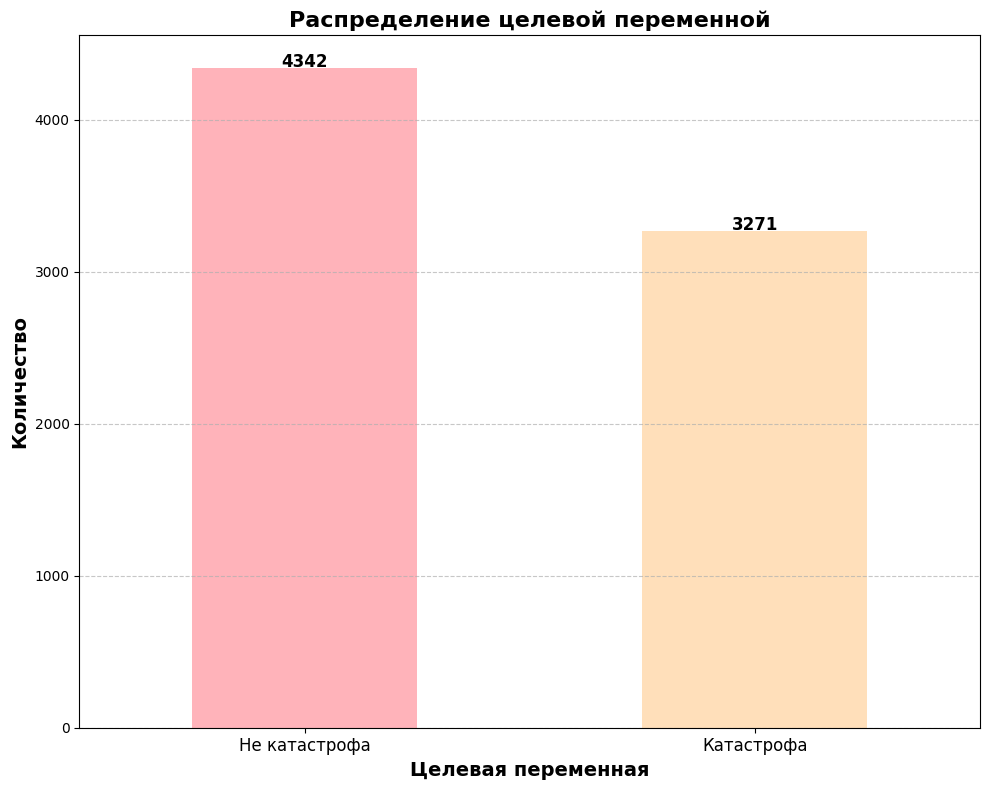

In [14]:
import matplotlib.pyplot as plt

# Увеличение размера графика
plt.figure(figsize=(10, 8))

# Пастельные цвета
colors = ['#FFB3BA', '#FFDFBA']  # Розовый для Non-Disaster, персиковый для Disaster
train['target'].value_counts().plot(kind='bar', color=colors)

# Добавление заголовка и меток осей
plt.title('Распределение целевой переменной', fontsize=16, fontweight='bold', family='sans-serif')
plt.xlabel('Целевая переменная', fontsize=14, fontweight='bold', family='sans-serif')
plt.ylabel('Количество', fontsize=14, fontweight='bold', family='sans-serif')

# Изменение меток на осях
plt.xticks(ticks=[0, 1], labels=['Не катастрофа', 'Катастрофа'], rotation=0, fontsize=12)

# Добавление сетки для осей
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Добавление аннотаций для ключевых данных
for index, value in enumerate(train['target'].value_counts()):
    plt.text(index, value + 5, str(value), ha='center', fontsize=12, fontweight='bold')

# Отображение графика
plt.tight_layout()  # Автоматическая подгонка элементов графика
plt.show()


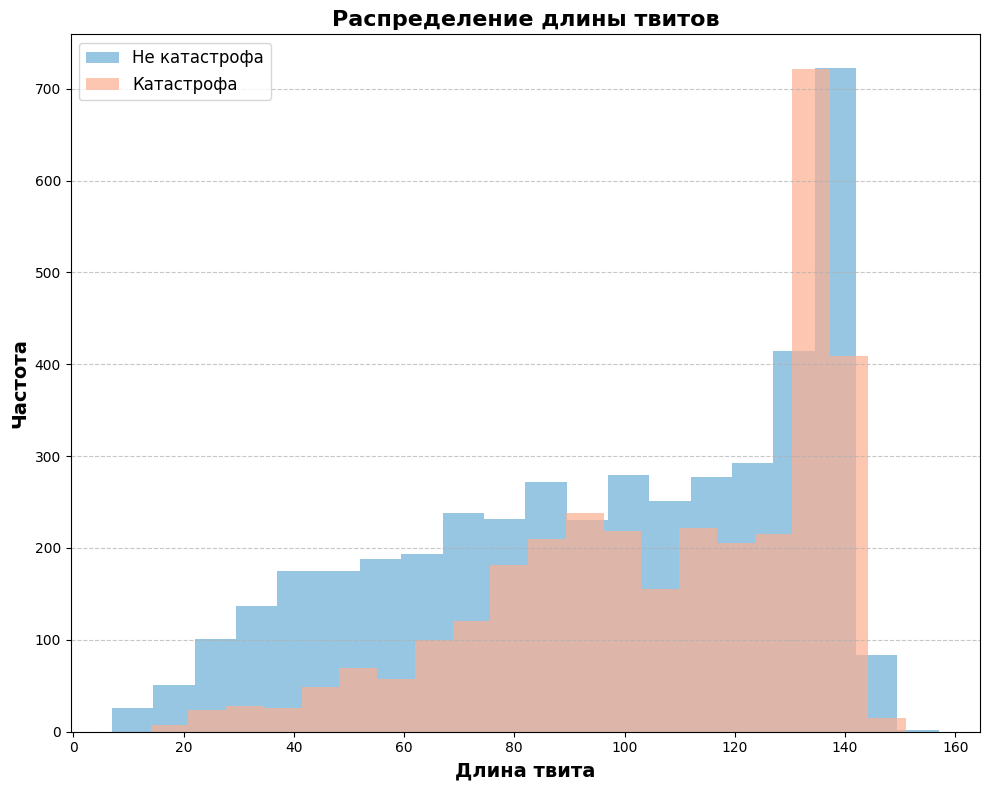

In [15]:
import matplotlib.pyplot as plt

# Вычисление длины твитов
train['tweet_length'] = train['text'].apply(len)

# Увеличение размера графика
plt.figure(figsize=(10, 8))

# Цвета, которые хорошо сочетаются
colors = ['#6BAED6', '#FCAE91']  # Голубой для Non-Disaster, персиковый для Disaster

# Построение гистограммы
plt.hist(train[train['target'] == 0]['tweet_length'], bins=20, color=colors[0], alpha=0.7, label='Не катастрофа')
plt.hist(train[train['target'] == 1]['tweet_length'], bins=20, color=colors[1], alpha=0.7, label='Катастрофа')

# Добавление заголовка и меток осей
plt.title('Распределение длины твитов', fontsize=16, fontweight='bold', family='sans-serif')
plt.xlabel('Длина твита', fontsize=14, fontweight='bold', family='sans-serif')
plt.ylabel('Частота', fontsize=14, fontweight='bold', family='sans-serif')

# Добавление легенды
plt.legend(fontsize=12)

# Добавление сетки для осей
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Отображение графика
plt.tight_layout()  # Автоматическая подгонка элементов графика
plt.show()


In [16]:
# Извлечение текстов катастрофических и некатастрофических твитов для дальнейшего анализа
disaster_tweets = train[train['target'] == 1]['text'].values
non_disaster_tweets = train[train['target'] == 0]['text'].values

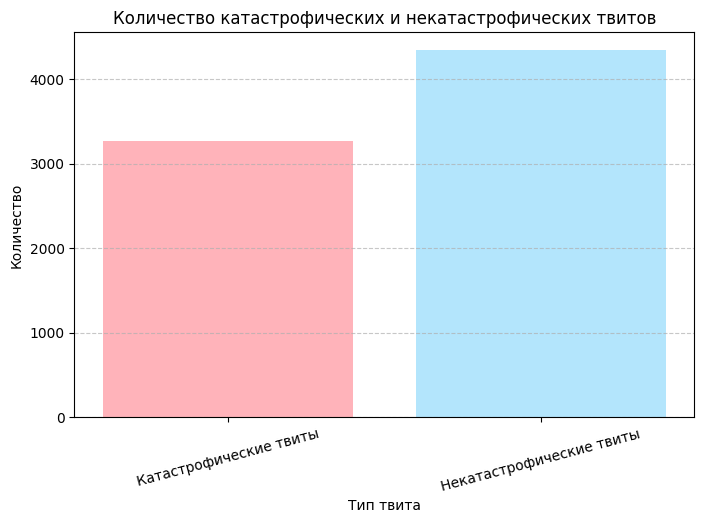

In [22]:
# Извлечение текстов катастрофических и некатастрофических твитов
disaster_tweets = train[train['target'] == 1]['text'].values
non_disaster_tweets = train[train['target'] == 0]['text'].values

# Визуализация количества твитов
labels = ['Катастрофические твиты', 'Некатастрофические твиты']
counts = [len(disaster_tweets), len(non_disaster_tweets)]

plt.figure(figsize=(8, 5))
plt.bar(labels, counts, color=['#FFB3BA', '#B3E5FC'])
plt.title('Количество катастрофических и некатастрофических твитов')
plt.xlabel('Тип твита')
plt.ylabel('Количество')
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Показать график
plt.show()


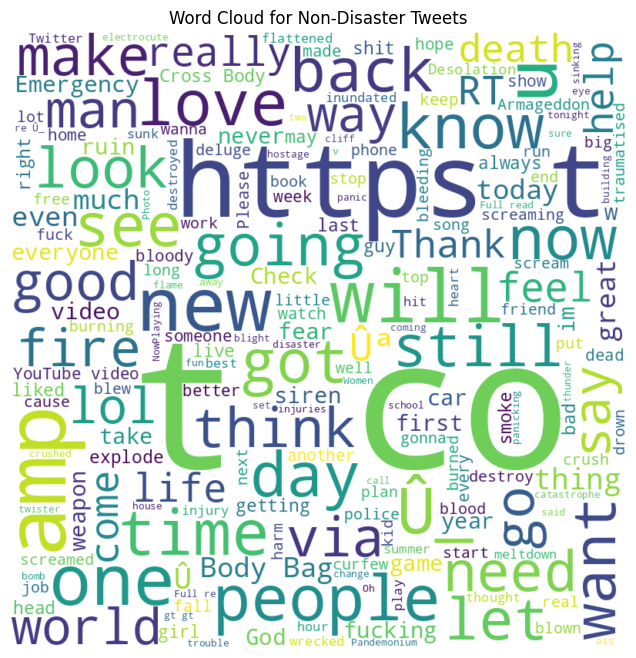

In [23]:
# Настройка графика для визуализации облака слов для некатастрофических твитов
plt.figure(figsize=(10, 8))
wordcloud_non_disaster = WordCloud(width=800, height=800, background_color='white').generate(" ".join(non_disaster_tweets))
plt.imshow(wordcloud_non_disaster, interpolation='bilinear')
plt.title('Word Cloud for Non-Disaster Tweets')
plt.axis('off')
plt.show()

In [25]:
# Функция для обучения и оценки модели
def train_and_evaluate_model(vectorizer, x_train, y_train, x_test, y_test):
    model_pipeline = Pipeline([
        ('vectorizer', vectorizer),
        ('model', LogisticRegression(C=0.8, solver='sag', max_iter=1000))
    ])

    model_pipeline.fit(x_train, y_train)

    train_score = model_pipeline.score(x_train, y_train)
    test_score = model_pipeline.score(x_test, y_test)

    y_pred = model_pipeline.predict(x_test)

    print(f"Train Score: {train_score:.4f}")
    print(f"Test Score: {test_score:.4f}")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    return model_pipeline

# Разделение данных
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

# Обучение модели с CountVectorizer
print("Training with CountVectorizer:")
count_vectorizer = CountVectorizer(ngram_range=(1, 1))
train_and_evaluate_model(count_vectorizer, x_train, y_train, x_test, y_test)

# Обучение модели с TfidfVectorizer
print("\nTraining with TfidfVectorizer:")
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 1))
model_tfidf = train_and_evaluate_model(tfidf_vectorizer, x_train, y_train, x_test, y_test)

# Создание файла для сабмита
submission = pd.DataFrame()
submission['id'] = test['id']
submission['target'] = model_tfidf.predict(test['text'])
submission.to_csv('submission.csv', index=False)

Training with CountVectorizer:
Train Score: 0.9673
Test Score: 0.8175
[[768 101]
 [177 477]]
              precision    recall  f1-score   support

           0       0.81      0.88      0.85       869
           1       0.83      0.73      0.77       654

    accuracy                           0.82      1523
   macro avg       0.82      0.81      0.81      1523
weighted avg       0.82      0.82      0.82      1523


Training with TfidfVectorizer:
Train Score: 0.8831
Test Score: 0.8024
[[765 104]
 [197 457]]
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       869
           1       0.81      0.70      0.75       654

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523

